In [1]:
!pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
appliances_energy_prediction = fetch_ucirepo(id=374) 
  
# data (as pandas dataframes) 
X = appliances_energy_prediction.data.features 
y = appliances_energy_prediction.data.targets 
  
# metadata 
#print(appliances_energy_prediction.metadata) 
  
# variable information 
print(appliances_energy_prediction.variables) 


           name     role        type demographic description  units  \
0          date  Feature        Date        None        None   None   
1    Appliances   Target     Integer        None        None     Wh   
2        lights  Feature     Integer        None        None     Wh   
3            T1  Feature  Continuous        None        None      C   
4          RH_1  Feature  Continuous        None        None      %   
5            T2  Feature  Continuous        None        None      C   
6          RH_2  Feature  Continuous        None        None      %   
7            T3  Feature  Continuous        None        None      C   
8          RH_3  Feature  Continuous        None        None      %   
9            T4  Feature  Continuous        None        None      C   
10         RH_4  Feature  Continuous        None        None      %   
11           T5  Feature  Continuous        None        None      C   
12         RH_5  Feature  Continuous        None        None      %   
13    

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from itertools import combinations
from sklearn.utils import resample
from scipy.special import comb
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors

torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_and_preprocess(timesteps=24):
    
    appliances_energy_prediction = fetch_ucirepo(id=374)
    X = appliances_energy_prediction.data.features
    y = appliances_energy_prediction.data.targets
    data = pd.concat([X, y], axis=1)
    
    if 'date' in data.columns:
        data = data.drop(columns=['date'])
    
    data = data.ffill().bfill()
    
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    
    X_seq, y_seq = [], []
    for i in range(len(scaled_data) - timesteps):
        X_seq.append(scaled_data[i:i+timesteps])
        y_seq.append(scaled_data[i+timesteps, -1])  # Target is last column
    
    return np.array(X_seq), np.array(y_seq), scaler, data.columns.tolist()

# Load data
X, y, scaler, feature_names = load_and_preprocess(timesteps=24)
print(f"Data shape: {X.shape}")
print(f"Features: {feature_names[:-1]}")

X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y).unsqueeze(1)

Data shape: (19711, 24, 28)
Features: ['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2']


In [4]:
train_size = int(0.8 * len(X))
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(X_test)}")

Training samples: 15768
Test samples: 3943


In [5]:
class ImprovedLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=3, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.3 if num_layers > 1 else 0  
        )
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()  # Non-linearity
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # LSTM output is (output, (h_n, c_n))
        out, _ = self.lstm(x)
        out = self.relu(self.fc1(out[:, -1, :]))  # Apply ReLU to the last hidden state
        out = self.fc2(out)
        return out

model = ImprovedLSTMModel(input_size=X.shape[2])
print(model)


ImprovedLSTMModel(
  (lstm): LSTM(28, 128, num_layers=3, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


Epoch 1/10, Loss: 0.0074
Epoch 2/10, Loss: 0.0046
Epoch 3/10, Loss: 0.0043
Epoch 4/10, Loss: 0.0043
Epoch 5/10, Loss: 0.0041
Epoch 6/10, Loss: 0.0041
Epoch 7/10, Loss: 0.0041
Epoch 8/10, Loss: 0.0040
Epoch 9/10, Loss: 0.0040
Epoch 10/10, Loss: 0.0040


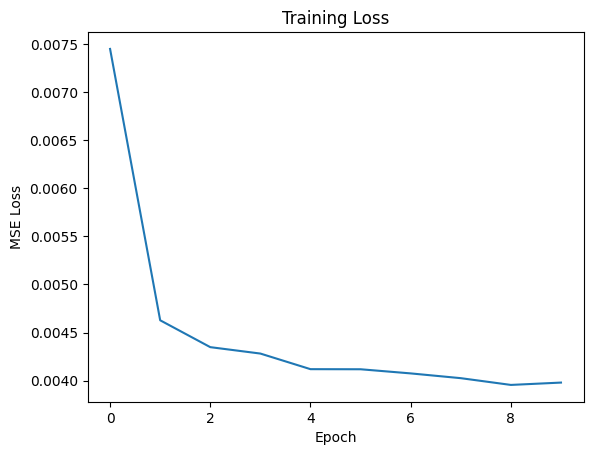

In [6]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10

# Training loop
train_losses = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')


plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

In [7]:
class LSTMTimeSeriesSHAP:
    def __init__(self, model, background_data, timesteps, feature_names, device='cpu'):
        self.model = model.to(device)
        self.model.eval()
        self.background = background_data.to(device)
        self.timesteps = timesteps
        self.n_features = background_data.shape[2]
        self.feature_names = feature_names
        self.device = device
        
        with torch.no_grad():
            self.baseline = self.model(self.background).mean().item()
    
    def shap_values(self, instance, nsamples=500, batch_size=64):
        instance = instance.to(self.device)
        if instance.shape != (1, self.timesteps, self.n_features):
            raise ValueError(f"Instance must have shape [1, {self.timesteps}, {self.n_features}]")
            
        masks = self._generate_temporal_masks(nsamples)
        masked_data = self._create_masked_data(instance, masks)
        
        preds = []
        for i in range(0, len(masked_data), batch_size):
            batch = masked_data[i:i+batch_size]
            with torch.no_grad():
                batch_preds = self.model(batch)
            preds.append(batch_preds.cpu().numpy())
        preds = np.concatenate(preds, axis=0)
        
        preds -= self.baseline
        
        return self._solve_shap(masks, preds).reshape((self.timesteps, self.n_features))
    
    def _generate_temporal_masks(self, nsamples):
        """Generate masks that respect temporal dependencies."""
        masks = []
        
        masks.append(np.ones((self.timesteps, self.n_features)))  # All features present
        masks.append(np.zeros((self.timesteps, self.n_features)))  # All features absent
        
        # Generate random masks with varied patterns across timesteps
        for _ in range(nsamples - 2):
            mask = np.zeros((self.timesteps, self.n_features))
            
            active_timesteps = np.random.choice(
                self.timesteps, 
                np.random.randint(1, self.timesteps), 
                replace=False
            )
            
            for t in active_timesteps:
                active_features = np.random.choice(
                    self.n_features, 
                    np.random.randint(1, self.n_features), 
                    replace=False
                )
                mask[t, active_features] = 1
            
            masks.append(mask)
        
        return np.array(masks)
    
    def _create_masked_data(self, instance, masks):
        """Create perturbed instances based on generated masks."""
        masked_data = []
        bg_samples = resample(
            self.background.cpu().numpy(),
            n_samples=len(masks),
            replace=True
        )
        
        for mask, bg in zip(masks, bg_samples):
            masked = bg * (1 - mask) + instance.cpu().numpy()[0] * mask
            masked_data.append(masked)
            
        return torch.FloatTensor(np.array(masked_data)).to(self.device)
    
    def _solve_shap(self, masks, preds):
        """Calculate SHAP values."""
        X = masks.reshape((len(masks), -1))
        X_with_intercept = np.hstack([X, np.ones((X.shape[0], 1))])
        weights = self._kernel_weights(X)
        W = np.diag(weights)
        XW = X_with_intercept.T @ W
        
        # Regularized matrix inversion
        regularization = 1e-4 * np.eye(X_with_intercept.shape[1])
        try:
            beta = np.linalg.inv(XW @ X_with_intercept + regularization) @ XW @ preds
            return beta[:-1]  # Exclude intercept
        except np.linalg.LinAlgError:
            # Fallback to pseudoinverse if still having issues
            beta = np.linalg.pinv(XW @ X_with_intercept) @ XW @ preds
            return beta[:-1]
    
    def _kernel_weights(self, X):
        """Improved kernel weight calculation."""
        M = X.shape[1]
        weights = []
        for x in X:
            ones = np.sum(x)
            if ones == 0 or ones == M:
                weight = 1e6  # High weight for extreme cases
            else:
                weight = (M - 1) / (comb(M, ones, exact=True) * ones * (M - ones) + 1e-10)
            weights.append(weight)
        return np.array(weights)


SHAP values shape: (24, 28)


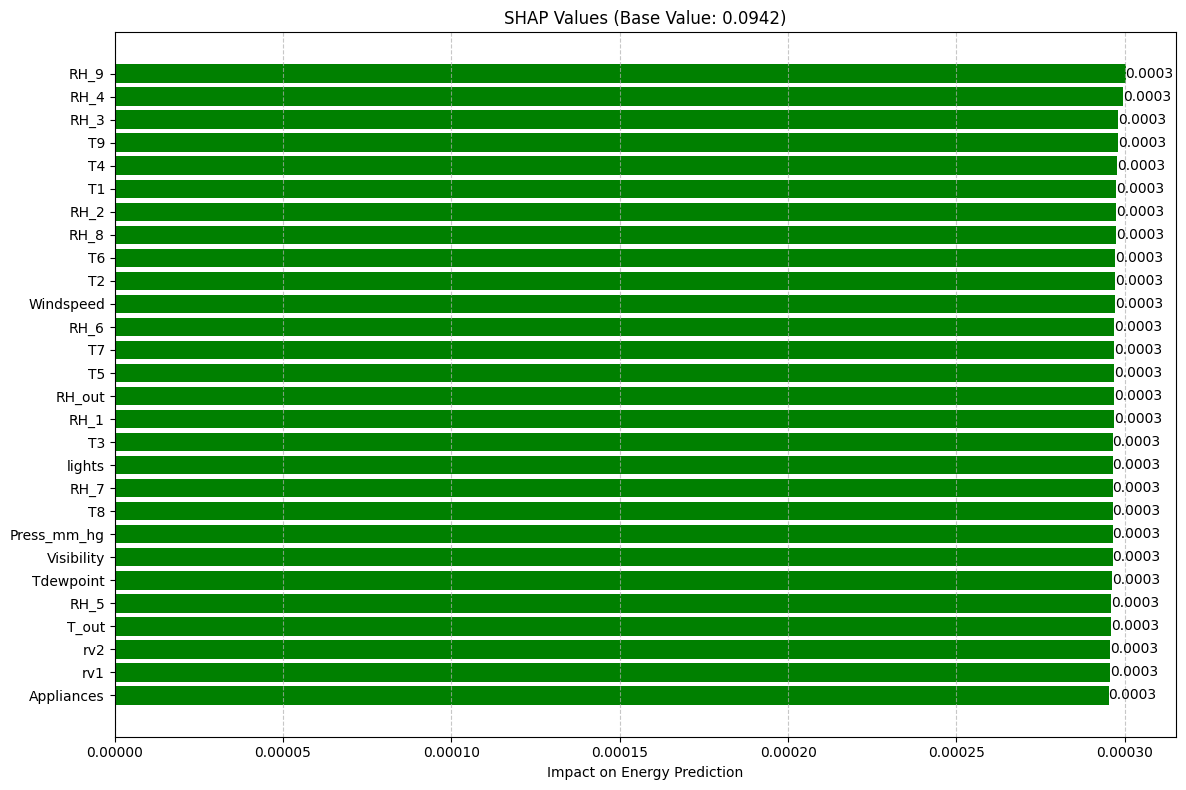

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


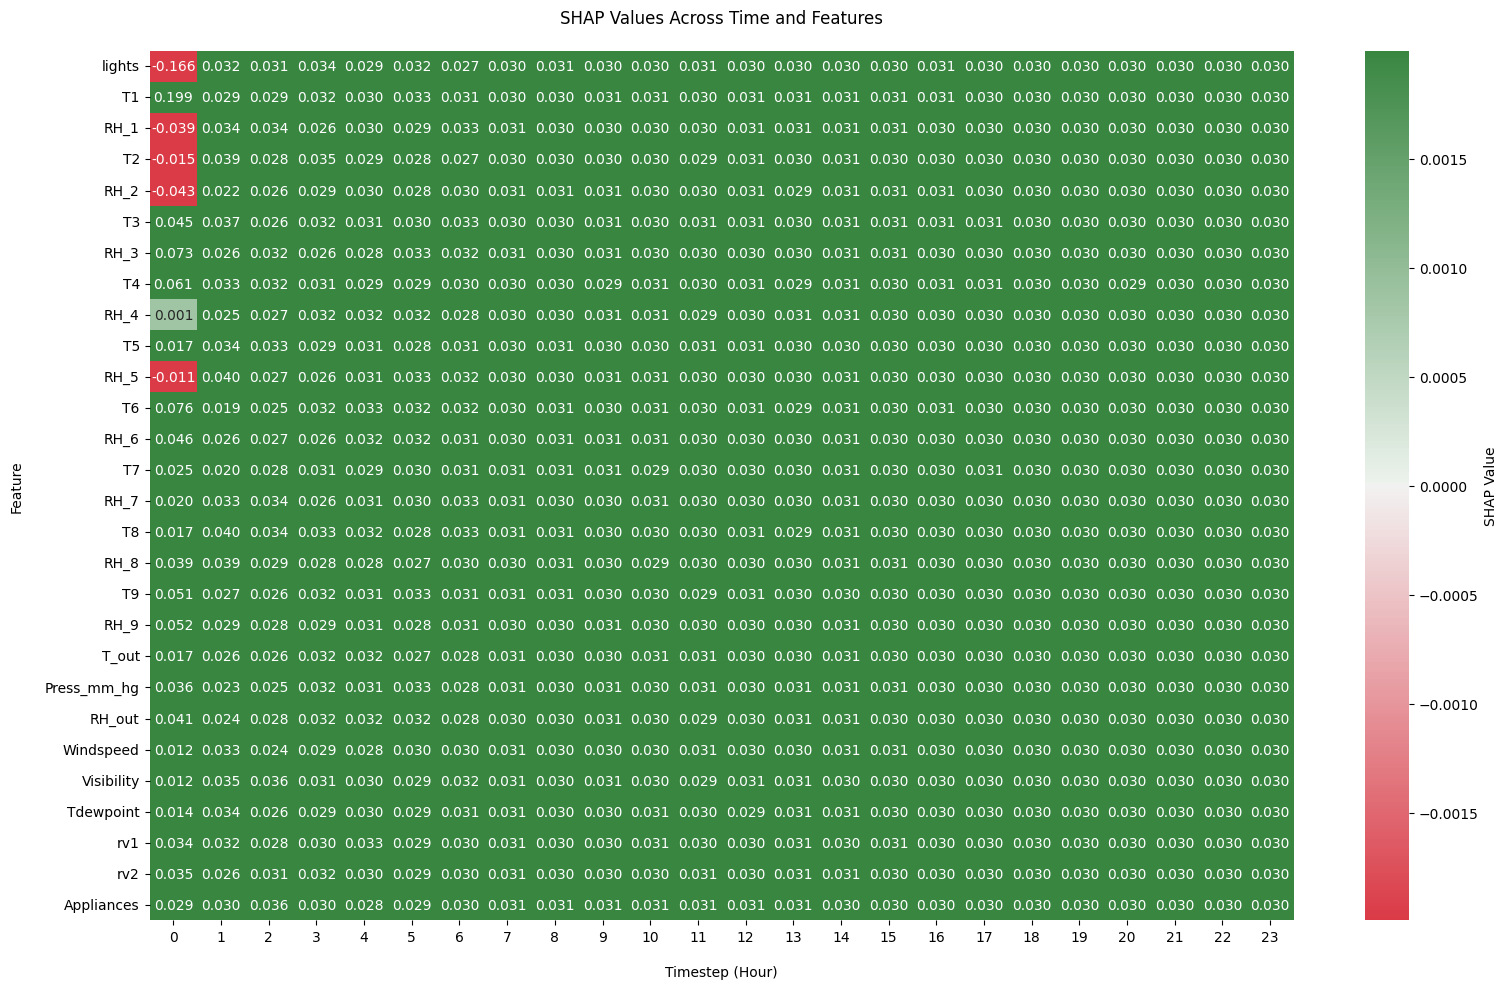

In [36]:
def waterfall_plot(shap_values, feature_names, baseline):
    """Waterfall plot to visualize SHAP values"""
    if len(shap_values.shape) > 1:
        shap_values_t = shap_values[-1]  # Use last timestep
    else:
        shap_values_t = shap_values
    shap_values_t = np.nan_to_num(shap_values_t, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Align feature names with SHAP values if there's a mismatch
    if len(shap_values_t) != len(feature_names):
        print(f"Warning: {len(shap_values_t)} SHAP values but {len(feature_names)} feature names")
        min_length = min(len(shap_values_t), len(feature_names))
        shap_values_t = shap_values_t[:min_length]
        feature_names = feature_names[:min_length]
    
    plt.figure(figsize=(12, 8))
    sorted_idx = np.argsort(shap_values_t)
    colors = ['red' if val < 0 else 'green' for val in shap_values_t[sorted_idx]]
    
    bars = plt.barh(range(len(sorted_idx)), shap_values_t[sorted_idx], color=colors)
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    
    for bar in bars:
        width = bar.get_width()
        plt.text(width if width > 0 else width - 0.02, 
                bar.get_y() + bar.get_height()/2,
                f'{width:.4f}',
                ha='left' if width > 0 else 'right',
                va='center')
    
    plt.title(f'SHAP Values (Base Value: {baseline:.4f})')
    plt.xlabel('Impact on Energy Prediction')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_shap_heatmap(shap_values, feature_names, timesteps_to_show=24):
    """Improved heatmap visualization"""
    # Limit the number of timesteps shown in the plot to avoid too large images
    timesteps_to_show = min(timesteps_to_show, shap_values.shape[0])
    start_idx = max(0, shap_values.shape[0] - timesteps_to_show)
    shown_values = shap_values[start_idx:]
    
    shown_values = np.nan_to_num(shown_values, nan=0.0, posinf=0.0, neginf=0.0)

    cmap = sns.diverging_palette(10, 130, as_cmap=True)
    
    # Plot with proper value scaling
    max_val = np.max(np.abs(shown_values))
    plt.figure(figsize=(16, 10))
    sns.heatmap(
        shown_values.T * 100,  # Scale the values for better visualization
        annot=True,
        fmt=".3f",
        cmap=cmap,
        center=0,
        vmin=-max_val,
        vmax=max_val,
        yticklabels=feature_names,
        xticklabels=range(start_idx, shap_values.shape[0]),
        cbar_kws={'label': 'SHAP Value'}
    )
    
    plt.title('SHAP Values Across Time and Features', pad=20)
    plt.xlabel('Timestep (Hour)', labelpad=15)
    plt.ylabel('Feature', labelpad=15)
    plt.tight_layout()
    plt.show()

instance = X_test[0:1].to(device)
shap_values = explainer.shap_values(instance, nsamples=200)

print(f"SHAP values shape: {shap_values.shape}")

# Visualize results
waterfall_plot(shap_values[-1], feature_names, explainer.baseline)
plot_shap_heatmap(shap_values, feature_names)
